ISA 414 Final Project <br> LSTM RNN

In [45]:
# standard python libraries
import requests
from requests import auth
import time
from time import sleep
import datetime as dt
from datetime import timezone
import collections
import random
import logging

# data handling
import pandas as pd
import numpy as np
import re
import pickle
import pymongo

# reddit API stuff
import praw
from psaw import PushshiftAPI
from praw.models import MoreComments

# stuff for doc2vec encoding
import gensim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext as tt

# visualization
import matplotlib.pyplot as plt

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [67]:
doc2vec_model = pickle.load(open('doc2vec_model.p', "rb"))
tsla_prices = pd.read_csv('TSLA_prices.csv')

In [81]:
top_10_tickers = ['GME', 'AMC', 'TSLA', 'AAPL', 'AMZN', 'AMD', 'NVDA', 'MSFT', 'SPY', 'QQQ']


def aggregate_posts_by_day(ticker):
    aggregated_daily_posts = {}
    posts = pickle.load(open(f'E:/reddit_data/{ticker}_series.p', "rb"))
    # replace UTC timestamp with date for easy aggregation
    for post in posts:
        day = dt.datetime.utcfromtimestamp(post.created_utc).date()
        delta = day.weekday() - 4
        if delta > 0:  # if day is weekend, aggregate to friday
            days_back = dt.timedelta(delta)
            day -= days_back

        if day not in aggregated_daily_posts:
            aggregated_daily_posts[day] = ''

            # aggregate titles
        if 'deleted by user' not in post.title and len(post.title) > 5:
            aggregated_daily_posts[day] = ' '.join([aggregated_daily_posts[day], post.title])

            # add bodytext if it exists and has not been deleted
            # WSB has minimum length requirements so the only posts less than 20 chars have been deleted
            if len(post.selftext) > 20:
                aggregated_daily_posts[day] = ' '.join([aggregated_daily_posts[day], post.selftext])

    return aggregated_daily_posts


# daily_posts = aggregate_posts_by_day('TSLA')


for ticker in top_10_tickers:
    daily_posts = aggregate_posts_by_day(ticker)
    for day in daily_posts:
        tokens = gensim.utils.simple_preprocess(daily_posts[day])
        daily_posts[day] = doc2vec_model.infer_vector(tokens)

    print(f'aggregated and vectorized {ticker} posts saved to disk')
    pickle.dump(daily_posts, open(f'E:/reddit_data/{ticker}_vectorized_posts.p', "wb"))

aggregated and vectorized GME posts saved to disk
aggregated and vectorized AMC posts saved to disk
aggregated and vectorized TSLA posts saved to disk
aggregated and vectorized AAPL posts saved to disk
aggregated and vectorized AMZN posts saved to disk
aggregated and vectorized AMD posts saved to disk
aggregated and vectorized NVDA posts saved to disk
aggregated and vectorized MSFT posts saved to disk
aggregated and vectorized SPY posts saved to disk
aggregated and vectorized QQQ posts saved to disk


In [83]:
gme_vectorized_posts = pickle.load(open(f'E:/reddit_data/GME_vectorized_posts.p', "rb"))
tsla_vectorized_posts = pickle.load(open(f'E:/reddit_data/TSLA_vectorized_posts.p', "rb"))

start_date = dt.date(2019, 4, 26)
print(len(gme_vectorized_posts))
print(len(tsla_vectorized_posts))

# print(gme_vectorized_posts[start_date])
print(tsla_vectorized_posts[start_date])


570
1155
[ 2.68807530e-01  2.34930679e-01 -1.24248719e+00  2.15990782e-01
 -1.26267469e+00  9.43141103e-01  2.07148939e-01 -2.06217146e+00
  8.50573778e-01 -1.70646977e+00 -1.25038230e+00 -1.76768506e+00
 -1.41640985e+00  7.80405760e-01 -1.40336704e+00 -2.08348691e-01
  1.83388329e+00  7.07498372e-01 -1.06029570e+00  1.30162621e+00
  1.16366887e+00 -8.18963468e-01 -8.71959090e-01  1.39438212e+00
  2.55059171e+00 -3.21400476e+00 -1.03838730e+00  1.09910131e+00
  1.72829759e+00 -2.63030791e+00  7.99790621e-01 -3.80284357e+00
  2.25078568e-01  2.46292496e+00  2.85395414e-01  3.39271992e-01
 -3.77949625e-01  1.13627565e+00  2.89728511e-02 -2.69969612e-01
  1.32208431e+00  1.35635030e+00  6.90649807e-01 -2.28580296e-01
  9.78374839e-01 -3.00479412e-01 -1.99153650e+00  1.03374159e+00
 -1.72021711e+00  5.04022837e-01  9.81748700e-01 -2.43253732e+00
 -5.90365887e-01 -1.64739287e+00 -2.77060723e+00 -9.58901465e-01
 -1.17912781e+00 -1.20655596e+00  8.22336853e-01  1.88973510e+00
  5.05529523e-01

In [48]:
price = tsla_prices[['close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['close'] = scaler.fit_transform(price['close'].values.reshape(-1, 1))
print(price)

         close
0    -0.987264
1    -0.983914
2    -0.983995
3    -0.983238
4    -0.982477
...        ...
1336  0.611612
1337  0.407947
1338  0.416472
1339  0.409773
1340  0.398467

[1341 rows x 1 columns]


C:\Users\admin\AppData\Local\Temp/ipykernel_7180/1789422434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['close'] = scaler.fit_transform(price['close'].values.reshape(-1,1))


Slice data and construct training/test sets

IDEA: convert UTC timestamp to date first, then aggregate

also test with sentiment api data

In [59]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()  # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]

    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]

    return [x_train, y_train, x_test, y_test]


lookback = 20  # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
# y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
# y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

Define model architecture

In [60]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [61]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 200

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

Train model over 100 epochs

In [63]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.0006914425175637007
Epoch  1 MSE:  0.0006903292378410697
Epoch  2 MSE:  0.000689229229465127
Epoch  3 MSE:  0.0006881427834741771
Epoch  4 MSE:  0.0006870694342069328
Epoch  5 MSE:  0.0006860087742097676
Epoch  6 MSE:  0.0006849610363133252
Epoch  7 MSE:  0.0006839257548563182
Epoch  8 MSE:  0.0006829025805927813
Epoch  9 MSE:  0.0006818916881456971
Epoch  10 MSE:  0.0006808924372307956
Epoch  11 MSE:  0.0006799049442633986
Epoch  12 MSE:  0.0006789290928281844
Epoch  13 MSE:  0.0006779642426408827
Epoch  14 MSE:  0.0006770105101168156
Epoch  15 MSE:  0.0006760676042176783
Epoch  16 MSE:  0.0006751353503204882
Epoch  17 MSE:  0.0006742133991792798
Epoch  18 MSE:  0.0006733016343787313
Epoch  19 MSE:  0.0006724001141265035
Epoch  20 MSE:  0.0006715083145536482
Epoch  21 MSE:  0.0006706262356601655
Epoch  22 MSE:  0.0006697536446154118
Epoch  23 MSE:  0.0006688901921734214
Epoch  24 MSE:  0.0006680359947495162
Epoch  25 MSE:  0.0006671907613053918
Epoch  26 MSE:  0.00066

Evaluate training and test accuracy


Test MSE:  0.0067209890112280846
[[ 49.848]
 [ 50.31 ]
 [ 50.266]
 ...
 [881.51 ]
 [877.51 ]
 [870.76 ]]


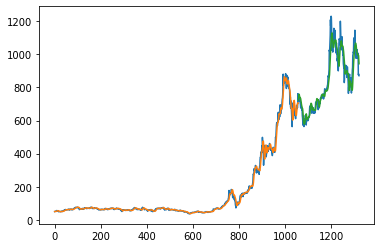

In [65]:
y_train_pred = model(x_train)  # forward
y_test_pred = model(x_test)

test_loss = criterion(y_test_pred, y_test_lstm)
print("Test MSE: ", test_loss.item())

y_train_unscaled = scaler.inverse_transform(y_train_pred.tolist())
y_test_unscaled = scaler.inverse_transform(y_test_pred.tolist())

# y_all_pred = y_train_pred + y_test_pred
y_gt = tsla_prices[['close']].to_numpy()[lookback:]
print(y_gt)
x_axis = range(len(y_train_pred))

# print(max(y_all_pred))
# unscaled_pred = scaler.inverse_transform(y_all_pred)
# print(max(unscaled_pred))
train_len = len(y_train_unscaled)
test_len = len(y_test_unscaled)

plt.plot(range(len(y_gt)), y_gt)
plt.plot(range(train_len), y_train_unscaled)
plt.plot(range(train_len, train_len + test_len), y_test_unscaled)

plt.show()
